# INTRODUCTION

**Prediction of the type of physical activity (e.g., walking, climbing stairs) from tri-axial smartphone accelerometer data**

Smartphone accelerometers are precise, and different physical activities give rise to varying acceleration patterns. The input data used for training in this project consists of two files. The first file, *train_time_series.csv*, contains the raw accelerometer data, it has the following format:

`timestamp`, `UTC time`, `accuracy`, `x`, `y`, `z`

We can use the timestamp column as our time variable; we'll also need the last three columns, here labeled x, y, and z, which correspond to measurements of linear acceleration along each of the three orthogonal axes.

The second file, *train_labels.csv*, contains the activity labels, and we'll be using these labels to train our model. Different activities have been numbered with integers. We use the following encoding: **1 = standing, 2 = walking, 3 = stairs down, 4 = stairs up**. Because the accelerometers are sampled at high frequency, the labels in *train_labels.csv* are only provided for every $10^{\text{th}}$ observation in *train_time_series.csv*.

Our goal is to classify different physical activities as accurately as possible. To test our code, we're also provided with a file called *test_time_series.csv*, we need to give the activity labels predicted by our code for this test data set.

### Importing the required libraries

 - Let us import and load all the required libraries before starting the data loading.
 - Also load all the traditional `sklearn-learn` classifiers which we will use in our code. 

In [1]:
# Importing the python libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import warnings
warnings.filterwarnings("ignore")
import time


# Importing the sklearn classifiers
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier

### Input and Load all the data
Next, input all training and testing data available as a seperate `Pandas` data framework using `.read_csv()` function. 

In [2]:
# Noting the starting time
start_time = time.time()


# Importing the training data
train_time=pd.read_csv("train_time_series.csv")
train_labels=pd.read_csv("train_labels.csv")


# Importing the testing data
test_time=pd.read_csv("test_time_series.csv")
test_labels=pd.read_csv("test_labels.csv")

### Removing the unnecessary columns
We see that `accuracy` column in both `train_time` and `test_time` is useless. Let us remove that column from both the dataframe.

In [3]:
# Using the .drop() method to drop the 'accuracy' column
train_time.drop("accuracy", axis = 1, inplace = True)
test_time.drop("accuracy", axis = 1, inplace = True)

### Convert ``UTC time`` to the pd.datetime format
Use `.to_datetime()` to acheive the task.

In [4]:
# Converting the 'UTC time' of training data
train_time['UTC time'] =  pd.to_datetime(train_time['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')
train_labels['UTC time'] =  pd.to_datetime(train_labels['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')


# Converting the 'UTC time' of testing data
test_time['UTC time'] =  pd.to_datetime(test_time['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')
test_labels['UTC time'] =  pd.to_datetime(test_labels['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')

### Check and count the number of `NaN` cells in our training data
We are interested in only numeric data. So, let us check if we have any `NaN` cell in our dataframes.

In [5]:
# First replacing the cells with value infinity to NaN
train_time = train_time.replace([np.inf, -np.inf], np.nan)
train_labels = train_labels.replace([np.inf, -np.inf], np.nan)


# Printing the count of NaN values in each coulmns
print("\nNo. of NaN values in the input training times:")
print(train_time.isnull().sum())
print("\nNo. of NaN values in the input training labels:")
print(train_labels.isnull().sum())


No. of NaN values in the input training times:
Unnamed: 0    0
timestamp     0
UTC time      0
x             0
y             0
z             0
dtype: int64

No. of NaN values in the input training labels:
Unnamed: 0    0
timestamp     0
UTC time      0
label         0
dtype: int64


### Imbalance in given input data
After careful examination of the labels of `train_labels` training data, we see that there are more number of label `2` when compared to other labels. This gives us additional challenge to face while implementing our traditional machine learning classifiers.

56.8% of labels are label 2
23.47% of labels are label 3
12.53% of labels are label 4
7.2% of labels are label 1


Text(0, 0.5, 'Count')

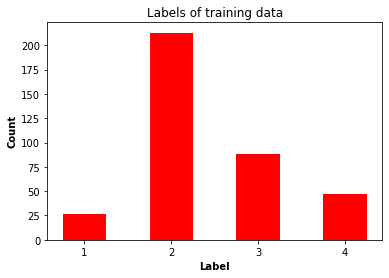

In [6]:
# Counting frequency of each label in the `train_time` dataframe
label_count = train_labels["label"].value_counts().to_dict()


# Calculating the percentage of each label
total_count=train_labels["label"].value_counts().sum()
for lab,cou in label_count.items():
    print("{}% of labels are label {}".format(round(cou/total_count*100,2),lab))

    
# Plotting the result for better understanding
plt.bar(label_count.keys(),label_count.values(),color="red", width=0.5)
plt.xticks(list(label_count.keys()))
plt.title("Labels of training data")
plt.xlabel("Label", fontweight='bold')
plt.ylabel("Count", fontweight='bold')

### Adding few more features to our input data
We are adding:
- Rolling average for acccelerations in x, y, z directions
- Rolling standard deviation for acccelerations in x, y, z directions
- Magnitude of acceleration (along x, y, z) and its rolling average and its rolling standard deviation
- Magnitude of acceleration (along x, y) and its rolling average and its rolling standard deviation
- Energy (frequency) of each acceleration

Note: Let us keep rolling window to be `4`, that is, number of observations to be used for each window to be `4`.

In [7]:
def rolling_averages_and_SD(data):
    '''
    data -> dataframe where rolling averages and standard deviations of x,y,z are to be added
    
    This function takes a dataframe as argument and first computes the rolling averages and
    standard deviations of x,y,z and store these computes values in new columns 'x_mean', 'y_mean',
    'z_mean', 'x_sd', 'y_sd', 'z_sd'.
    
    Finally returns the dataframe.
    '''
    data["x_mean"] = data["x"].rolling(window = 4).mean() 
    data["y_mean"] = data["y"].rolling(window = 4).mean() 
    data["z_mean"] = data["z"].rolling(window = 4).mean()
    data["x_sd"] = data["x"].rolling(window = 4).std()
    data["y_sd"] = data["y"].rolling(window = 4).std() 
    data["z_sd"] = data["z"].rolling(window = 4).std()
    return data


def add_magnitude(data):
    '''
    data -> dataframe where rolling averages and standard deviations of x,y,z are to be added
    
    This function computes the magnitude of acceleration using acceleration along x,y,z axis 
    and store them in a new column "magnitude". Next, rolling average and standard deviation
    of the "magnitude" is calculated and stored in new columns "m_mean" and "m_sd".
    
    Finally returns the dataframe.
    '''
    mag = (data['x'] ** 2) + (data['y'] ** 2 ) + (data['z'] ** 2 )
    mag = mag.apply(lambda x: math.sqrt(x))
    data['magnitude'] = mag
    data["m_mean"] = data["magnitude"].rolling(window = 4).mean()
    data["m_sd"] = data["magnitude"].rolling(window = 4).std()
    return data


def add_hor_magnitude(data):
    '''
    data -> dataframe where rolling averages and standard deviations of x,y,z are to be added
    
    This function computes the magnitude of horizontal acceleration using acceleration along x,y
    axis and store them in a new column "hor_magnitude". Next, rolling average and standard deviation
    of the "hor_magnitude" is calculated and stored in new columns "m_hor_mean" and "m_hor_sd".
    
    Finally returns the dataframe.
    '''
    mag = (data['x'] ** 2) + (data['y'] ** 2 )
    mag = mag.apply(lambda x: math.sqrt(x))
    data['hor_magnitude'] = mag
    data["m_hor_mean"] = data["hor_magnitude"].rolling(window = 4).mean()
    data["m_hor_sd"] = data["hor_magnitude"].rolling(window = 4).std()
    return data


def add_energy(data):
    '''
    data -> dataframe where rolling averages and standard deviations of x,y,z are to be added
    
    This function computes the energy of acceleration along x,y,z and store them in new columns
    'x_E','y_E','z_E'. Energy is related to the frequency of the signal according to the Parseval's
    theorem. 
    
    Finally returns the dataframe.
    '''
    data["x_E"] = (data["x"]**2).rolling(window = 4).sum()
    data["y_E"] = (data["y"]**2).rolling(window = 4).sum() 
    data["z_E"] = (data["z"]**2).rolling(window = 4).sum()
    return data

In [8]:
# Let us first add new features to training dataset
train_time=rolling_averages_and_SD(train_time)
train_time=add_magnitude(train_time)
train_time=add_hor_magnitude(train_time)
train_time=add_energy(train_time)


# Now, let us add new features to testing dataset
test_time=rolling_averages_and_SD(test_time)
test_time=add_magnitude(test_time)
test_time=add_hor_magnitude(test_time)
test_time=add_energy(test_time)

### Generating subset from given `trian_time` and `test_time`

Since, both in `train_labels` and `test_labels`, data is available only for every $10^{\text{th}}$ observation in the `train_time` and `test_time` dataframes respectively. We are generating two new dataframes `sub_train_time` and `sub_test_time` containing training data for all the labels available in `train_labels` and `test_labels` dataframe.

In [9]:
def get_subset(start_ind, data):
    '''
    start_ind -> Value of "Unnamed: 0" at which subset generation to be started
    data -> Dataframe whose subset is to be generated
    
    This function takes a dataframe as a argument and generate a new subset and 
    returns the newly generated subset.
    '''
    ind=np.arange(start_ind, start_ind+len(data), 10)
    sub_data=data[data["Unnamed: 0"].isin(ind)]
    return sub_data


'''
After eyeballing of `train_labels` and `test_labels`, I fixed starting value
of "Unnamed: 0" as 20589 and 24339 respectively. Now, let us generate the new
subsets.
'''
sub_train_time=get_subset(20589,train_time)
sub_test_time=get_subset(24339,test_time)


# Storing the subsets as seperate '.csv' files for future use
sub_train_time.to_csv("sub_train_time.csv", mode="w")
sub_test_time.to_csv("sub_test_time.csv", mode="w")

### Data visualisation

In the following couple of exercise, we will be plotting the data and check if there is any requirement for pre-processing.

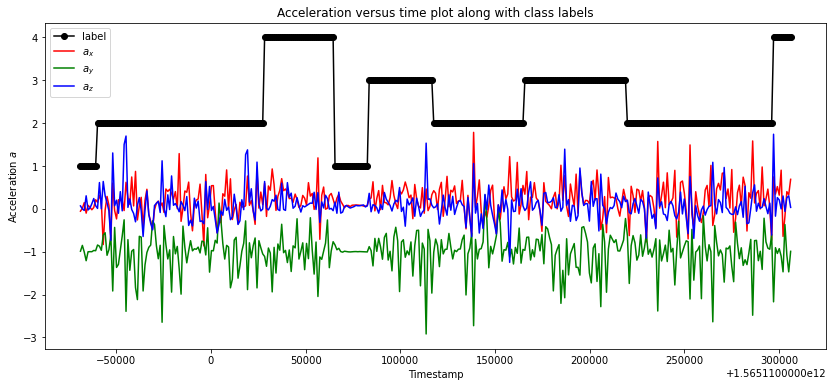

In [10]:
# Fixing the figure size
plt.figure(figsize=(14,6))


# Plotting the training subsets and labels
plt.plot(train_labels["timestamp"], train_labels["label"], "ko-", label="label");
plt.plot(sub_train_time["timestamp"], sub_train_time["x"], "r-", label="$a_x$");
plt.plot(sub_train_time["timestamp"], sub_train_time["y"], "g-", label="$a_y$");
plt.plot(sub_train_time["timestamp"], sub_train_time["z"], "b-", label="$a_z$");


# Setting up the axis labels. legends and plot title
plt.xlabel("Timestamp")
plt.ylabel("Acceleration $a$")
plt.title("Acceleration versus time plot along with class labels")
plt.legend();

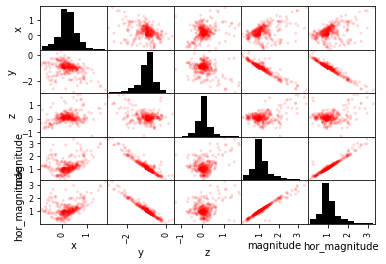

  Skewness for x : 0.293015298378273
  Skewness for y : -1.1067278282407886
  Skewness for z : 1.3139559582589213
  Skewness for magnitude : 1.5706658221945047
  Skewness for hor_magnitude : 1.3218782490817123


In [11]:
plotting_variables = ['x', 'y', 'z','magnitude','hor_magnitude']
axes = pd.plotting.scatter_matrix(sub_train_time[plotting_variables], alpha=0.15, \
       color=(0,0,0), hist_kwds={"color":(0,0,0)}, facecolor=(1,0,0))


# Let us visualise the plot
plt.show()


# Now, let us find and print the skewness
for column in ["x","y","z","magnitude","hor_magnitude"]:
    s = ss.skew(sub_train_time[column])
    print('  Skewness for {} : {}'.format(column, s)) 

We note that the `y` is left skewed and `z`, `magnitude`, `hor_magnitude` are right skewed. To remove these skewness in our data, we are going to transform these variable. Following are the kinds of transformation we will do in our data:
- Right skewed data: Log base 10 transformation
- Left skewed data: Reflect, followed by log base 10 transformation. "Reflect" means to take the largest observation, $\alpha$, then subtract each observation from $\alpha$ + 1.

Note: while taking log base 10 for any 'x', we should ensure that 'x'>0. Since some of the data are negative, after eyeballing the data, we are adding `2.2`, `0.3`, `0.6` to `z`, `magnitude`, `hor_magnitude` respectively inorder to make log base 10 transformation possible. 

In [12]:
# Transforming the left skewed 'y'
sub_train_time['y'] = sub_train_time['y'].apply(lambda x: sub_train_time['y'].max()+1-x)
sub_train_time['y'] = np.log10(sub_train_time['y'])


# Transforming the right skewed variables
sub_train_time['z'] = np.log10(sub_train_time['z']+2.2)
sub_train_time['magnitude'] = np.log10(sub_train_time['magnitude']+0.3)
sub_train_time['hor_magnitude'] = np.log10(sub_train_time['hor_magnitude']+0.6)

Let us plot and recheck the skewness. Reasonable skewness cutoffs for zero skewness in large samples are 0.4 and -0.4

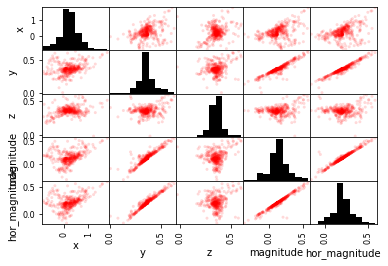

  Skewness for x : 0.293015298378273
  Skewness for y : 0.14189289080841813
  Skewness for z : -0.014816821068750301
  Skewness for magnitude : 0.1723595360205174
  Skewness for hor_magnitude : 0.18904333674328705


In [13]:
plotting_variables = ['x', 'y', 'z','magnitude',"hor_magnitude"]

axes = pd.plotting.scatter_matrix(sub_train_time[plotting_variables], alpha=0.15, \
       color=(0,0,0), hist_kwds={"color":(0,0,0)}, facecolor=(1,0,0))


# Again, let us visualise the plot
plt.show()


# Now, let us again find and print the skewness
for column in ["x","y","z","magnitude","hor_magnitude"]:
    s = ss.skew(sub_train_time[column])
    print('  Skewness for {} : {}'.format(column, s)) 

### Selecting the classifier with highest accuracy

- We will split training data into two parts, use the first part to train the classifiers and the second part to test the classifiers.
- We will choose the classifier with highest accuracy.
- Then in the upcoming excercise, we will do hypertuning of the selected classifier to increase its accuracy.

In [14]:
# Let us first define the variable which we will use for model fitting.
interest_variables = [
    'z','hor_magnitude','timestamp', 'x_mean','y_mean','z_mean','x_sd',\
    'y_sd','z_sd','m_mean','m_sd','m_hor_mean','m_hor_sd','x_E','y_E','z_E'
]

classifiers = {
    'RidgeClassifier' : RidgeClassifier(),
    'RidgeClassifier_chol' : RidgeClassifier(solver='cholesky'),
    'LogisticRegression' : LogisticRegression(solver='saga', multi_class='multinomial'),
    'RandomForestClassifier' : RandomForestClassifier(),
    'RandomForestClassifier_ent' : RandomForestClassifier(criterion='entropy'),
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'DecisionTreeClassifier_ent' : DecisionTreeClassifier(criterion='entropy'),
    'ExtraTreeClassifier' : ExtraTreeClassifier(),
    'ExtraTreeClassifier_ent' : ExtraTreeClassifier(criterion='entropy'),
    'ExtraTreesClassifier' : ExtraTreesClassifier(),
    'ExtraTreesClassifier_ent' : ExtraTreesClassifier(criterion='entropy'),
    'QuadraticDiscriminantAnalysis' : QuadraticDiscriminantAnalysis()
}


def search_best_classifier(N=20, test_size=0.15, tree_depth=4, cutoff=0.6):
    '''
    N -> number of random splits
    test_size -> proportion of the test dataset 
    tree_depth -> maximum depth of tree/forest classifiers
    cutoff -> only print scores above a certain value (for easier eyeballing)
    
    
    This function tests a suit of classifiers on the same randomly split datasets, and prints 
    out the average score for each classifier that scores above the cutoff value
    '''
    for key in classifiers.keys():
        if 'Tree' in key or 'Forest' in key:
            classifiers[key].set_params(max_depth=tree_depth)
            
    scores = {}    
    for key in classifiers.keys():
        scores[key] = []
        
    for ii in range(N):
        input_train, input_test, label_train, label_test = train_test_split(sub_train_time[interest_variables], train_labels['label'], test_size=test_size, random_state=ii)
        for key, classifier in classifiers.items():
            classifier.fit(input_train, label_train)
            score = classifier.score(input_test, label_test)
            scores[key].append(score)
            
    for key, score_arr in scores.items(): 
        avg_score = np.mean(score_arr)
        if avg_score>=cutoff:
            print('Tree depth: {}, Test size: {}, Score for {}: {:0.4}%'.format(tree_depth, test_size, key, avg_score*100))
            
for tree_d in range(10,21):   
    for test_s in range(5, 26, 5):
        search_best_classifier(N=20, test_size=test_s/100, tree_depth=tree_d, cutoff=0.735)

Tree depth: 10, Test size: 0.05, Score for ExtraTreesClassifier: 73.68%
Tree depth: 12, Test size: 0.1, Score for ExtraTreesClassifier: 74.08%
Tree depth: 12, Test size: 0.1, Score for ExtraTreesClassifier_ent: 73.55%
Tree depth: 14, Test size: 0.1, Score for ExtraTreesClassifier: 73.82%
Tree depth: 15, Test size: 0.1, Score for ExtraTreesClassifier_ent: 73.55%
Tree depth: 16, Test size: 0.05, Score for ExtraTreesClassifier: 73.95%
Tree depth: 16, Test size: 0.1, Score for ExtraTreesClassifier: 73.55%
Tree depth: 17, Test size: 0.1, Score for ExtraTreesClassifier_ent: 74.21%


We found that `ExtraTreesClassifier` with criterion=`entropy` gave the highest accuracy on our training data. Now, before hypertuning of the `ExtraTreesClassifier` classifier, let us plot and see if pre-processing of test data is required.

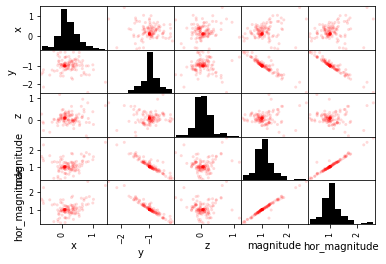

  Skewness for x : 0.32906346391739427
  Skewness for y : -0.7300576567658518
  Skewness for z : 0.7685738370966831
  Skewness for magnitude : 1.1739329915323307
  Skewness for hor_magnitude : 1.0408286818796528


In [15]:
plotting_variables = ['x', 'y', 'z','magnitude',"hor_magnitude"]

axes = pd.plotting.scatter_matrix(sub_test_time[plotting_variables], alpha=0.15, \
       color=(0,0,0), hist_kwds={"color":(0,0,0)}, facecolor=(1,0,0))


# Let us visualise the plot
plt.show()


# Now, let us find and print the skewness
for column in ["x","y","z","magnitude","hor_magnitude"]:
    s = ss.skew(sub_test_time[column])
    print('  Skewness for {} : {}'.format(column, s)) 

We are applying similar transformation to our testing variables as of our training variables.

In [16]:
# Transforming the left skewed 'y'
sub_test_time["y"] = sub_test_time["y"].apply(lambda x: sub_test_time["y"].max()+1-x)
sub_test_time['y'] = np.log10(sub_test_time['y'])


# Transforming the right skewed variables
sub_test_time['z'] = np.log10(sub_test_time['z']+2.2)
sub_test_time['magnitude'] = np.log10(sub_test_time['magnitude']+0.3)
sub_test_time["hor_magnitude"] = np.log10(sub_test_time['hor_magnitude']+0.6)

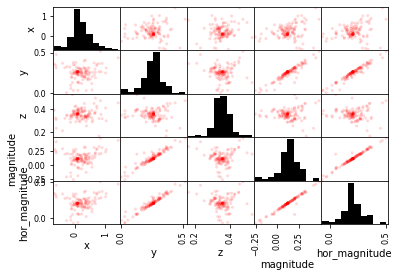

  Skewness for x : 0.32906346391739427
  Skewness for y : -0.3288710248104197
  Skewness for z : -0.05521924064271837
  Skewness for magnitude : -0.28342952164693463
  Skewness for hor_magnitude : -0.13120071907265957


In [17]:
plotting_variables = ['x', 'y', 'z','magnitude',"hor_magnitude"]

axes = pd.plotting.scatter_matrix(sub_test_time[plotting_variables], alpha=0.15, \
       color=(0,0,0), hist_kwds={"color":(0,0,0)}, facecolor=(1,0,0))


# Again, let us visualise the plot
plt.show()


# Now, let us again find and print the skewness
for column in ["x","y","z","magnitude","hor_magnitude"]:
    s = ss.skew(sub_test_time[column])
    print('  Skewness for {} : {}'.format(column, s)) 

### Hypertuning of the best classifier
First let us see the parameter of the estimator (our best classifier) using the `.get_params()` function.

In [18]:
ef = ExtraTreesClassifier()
ef.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Now, let us utilise the "fit" and "score" technique of `GridSearchCV` to optimise (hypertuning) the parameter of the estimator (our best classifier). The parameters of the estimator are optimized by cross-validated grid-search over a parameter grid.

In [19]:
# Let us create a parameter grid, which is to be used for grid search.
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ef, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
input_train, input_test, label_train, label_test = train_test_split(sub_train_time[interest_variables], train_labels['label'], test_size=0.05)
grid_result= grid_search.fit(input_train, label_train)


# Printing the parameter setting that gave the best results
grid_result.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [20]:
def performance_measure(model, test_features, test_labels):
    '''
    model -> Estimator which gave highest score
    test_features -> testing time series
    test_labels -> testing labels
    
    This function estimates the accuracy and error of our best model. It returns the 
    accuracy of the model.
    '''
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('>>> Model Performance <<<')
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%'.format(accuracy))
    return accuracy

best_grid = grid_result.best_estimator_ #Estimator which gave highest score
grid_accuracy = performance_measure(best_grid, input_test, label_test) #Function call to find the accuracy of the estimator

>>> Model Performance <<<
Average Error: 0.3684
Accuracy = 88.60%


### Finally, let us predict the labels of the `sub_test_time` data

We will write the predicted labels on the file `my_output_labels.csv`

88.0% of labels are label 2
12.0% of labels are label 1


Text(0, 0.5, 'Count')

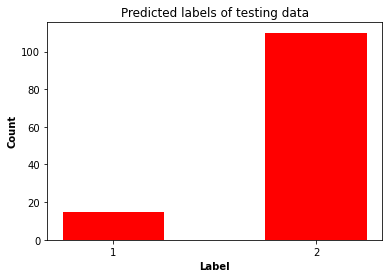

In [21]:
test_labels["label"]=best_grid.predict(sub_test_time[['z','hor_magnitude','timestamp', 'x_mean','y_mean','z_mean','x_sd','y_sd','z_sd','m_mean','m_sd','m_hor_mean','m_hor_sd','x_E','y_E','z_E']])
test_labels.to_csv('my_output_labels.csv', mode='w')


# Calculating the percentage of each label predicted by our model
test_label_count=test_labels["label"].value_counts().to_dict()
total_count=test_labels["label"].value_counts().sum()
for lab,cou in test_label_count.items():
    print("{}% of labels are label {}".format(round(cou/total_count*100,2),lab))

    
# Plotting the result for better understanding
plt.bar(test_label_count.keys(),test_label_count.values(),color="red", width=0.5)
plt.xticks(list(test_label_count.keys()))
plt.title("Predicted labels of testing data")
plt.xlabel("Label", fontweight='bold')
plt.ylabel("Count", fontweight='bold')

**Printing the time taken by my code**

In [22]:
total_time = time.time() - start_time  
mins = math.floor(total_time / 60)
secs = total_time % 60
if mins > 0:
    print('\nTotal time: {} mins {:0.2f} secs'.format(mins, secs))
else:
    print('\nTotal time: {:0.2f} seconds'.format(secs))


Total time: 17 mins 8.68 secs


### Conclusion

As shown above, our selected classifier showed a good accuracy. But majority of our predicted labels are belonging to class `2` (Walking). That is expected, because we saw already that there is clearly a imbalance in the training labels. So, our model is labelling the most of the test data as class `2` because of clear imbalance in our `sub_train_time`.